![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [4]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

In [5]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Punto 1 - Árbol de decisión manual

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

In [5]:
# Celda 1
import numpy as np

def mse(y):
    if y.shape[0] == 0:
        return 0
    else:
        return np.mean((y - y.mean())**2)

# Definición de la función mse_reduction para calular la ganancia de una variable predictora j dado el punto de corte k
def mse_reduction(X_col, y, split):
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    if n_l == 0 or n_r == 0:
        return 0
    
    mse_y = mse(y)
    mse_l = mse(y_l)
    mse_r = mse(y_r)
    
    result = mse_y - (n_l / (n_l + n_r) * mse_l + n_r / (n_l + n_r) * mse_r)
    
    return result

# Definición de la función best_split para calcular cuál es la mejor variable y punto de corte
# para hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    features = range(X.shape[1])
    
    best_split = [0, 0, 0]  # j, split, reduction
    
    # Para todas las variables 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
            reduction = mse_reduction(X.iloc[:, j], y, split)
                        
            if reduction > best_split[2]:
                best_split = [j, split, reduction]
    
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'
def tree_predict(X, tree):
    
    predicted = np.ones(X.shape[0]) * tree['y_pred']

    # Revisar si es el nodo final
    if tree['split'] == -1:
        return predicted
    else:
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacío
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:  # Si el nodo derecho está vacío
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted

tree = tree_grow(X_train, y_train)

predictions = tree_predict(X_test, tree)

rmse = np.sqrt(np.mean((y_test - predictions)**2))
mae = np.mean(np.abs(y_test - predictions))

print(f" RMSE: {rmse}")
print(f" MAE: {mae}")

 RMSE: 2118.1381268232594
 MAE: 1581.5196785989222


In [6]:
tree = tree_grow(X_train, y_train, max_depth = 3)

predictions = tree_predict(X_test, tree)

rmse = np.sqrt(np.mean((y_test - predictions)**2))
mae = np.mean(np.abs(y_test - predictions))

print(f" RMSE: {rmse}")
print(f" MAE: {mae}")

 RMSE: 1921.0003286740282
 MAE: 1445.809132588749


Probando diferentes max_depth observamos una mejora en las métricas por lo que decidimos dejarlo en 3. Además esto también ayudame a mejorar los tiempos de ejecución.

### Punto 2 - Bagging manual

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

In [7]:
# Celda 2
# Usaremos el árbol manual que diseñamos anteriormente
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

n_B = 10
n_samples = X_train.shape[0]
np.random.seed(123)
samples = [np.random.choice(a=X_train.index, size=n_samples, replace=True) for _ in range(n_B)]

predictions = []

for i, sample_idx in enumerate(samples):
    X_bootstrap = X_train.loc[sample_idx]
    y_bootstrap = y_train.loc[sample_idx]
    
    tree = tree_grow(X_bootstrap, y_bootstrap, max_depth = 3)

    y_pred_i = tree_predict(X_test, tree)
    predictions.append(y_pred_i)

# Promediamos los resultados de las predicciones
y_pred_bag_manual = np.mean(predictions, axis=0)

rmse_bag_manual = np.sqrt(mean_squared_error(y_test, y_pred_bag_manual))
mae_bag_manual = mean_absolute_error(y_test, y_pred_bag_manual)
r2_bag_manual = r2_score(y_test, y_pred_bag_manual)

print(f" RMSE bagging manual: {rmse_bag_manual}")
print(f" MAE bagging manual: {mae_bag_manual}")
print(f" R cuadrado bagging manual: {r2_bag_manual}")

 RMSE bagging manual: 1832.6459868667998
 MAE bagging manual: 1376.3908840327795
 R cuadrado bagging manual: 0.7804289159004457


###  Bagging manual (10 árboles)

Implementamos manualmente un modelo de Bagging utilizando árboles de decisión, calculados manualmente también.

El procedimiento consistió en:

1. Generar 10 muestras bootstrap a partir del conjunto de entrenamiento.
2. Entrenar un árbol de decisión manual por cada muestra, usando la función `tree_grow` desarrollada previamente.
3. Predecir sobre el conjunto de prueba con cada uno de los árboles.
4. Promediar las predicciones para obtener el valor final de predicción para cada observación del test.

#### Configuración:
- Número de árboles (`n_estimators`): 10.
- Modelo: árbol de decisión manual con `max_depth` = 3
- Muestras bootstrap: generadas de manera aleatoria manualmente.

#### Resultados en el conjunto de prueba (`X_test`, `y_test`):
- RMSE (Root Mean Squared Error): 1832.65  
- MAE (Mean Absolute Error): 1376.39
- R cuadrado: 0.78

#### Comentario:
El modelo de Bagging manual logró un mejor desempeño que un árbol individual, reduciendo el error de predicción. Esto nos demuestra el efecto positivo del bagging en la disminución de la varianza. Por otro lado, viendon el R cuadrado, vemos que el 78% de los casos son explicables utilizando este modelo.


### Punto 3 - Bagging con librería

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

In [8]:
# Celda 3
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

n_features = X_train.shape[1]
max_features = int(np.log(n_features))

# Definimos el modelo base, un árbol de regresión, y utilizamos BagginRegressor de sklearn
base_tree = DecisionTreeRegressor()
bagging_model = BaggingRegressor(
    base_estimator=base_tree,
    n_estimators=10,
    max_features=max_features,
    random_state=123
)

bagging_model.fit(X_train, y_train)

y_pred_bag = bagging_model.predict(X_test)

# Evaluamos el modelo utilizando las funciones de sklearn.
rmse_bag = np.sqrt(mean_squared_error(y_test, y_pred_bag))
mae_bag = mean_absolute_error(y_test, y_pred_bag)
r2_bag = r2_score(y_test, y_pred_bag)

print(f" RMSE bagging sklearn: {rmse_bag}")
print(f" MAE bagging sklearn: {mae_bag}")
print(f" R caudrado bagging sklearn: {r2_bag}")


 RMSE bagging sklearn: 2144.2687117758824
 MAE bagging sklearn: 1625.3628868685505
 R caudrado bagging sklearn: 0.6994087025531126


###  Bagging sklearn (10 árboles)

Implementamos un modelo de Bagging utilizando árboles de decisión a través de la librería de `sklearn`.

El procedimiento consistió en:

1. Generar un modelo base.
2. Definir el modelo de Bagging con los parámetros necesarios.
3. Entrenar el modelo.
4. Predecir sobre el conjunto de prueba.
5. Calcular las métricas del modelo.

#### Configuración:
- `n_estimators`: 10.
- `Max_features`: Utilizamos la regla descrita en el enunciado.
- `base_estimator`: Árbol de decisión por default de `sklearn`.

#### Resultados en el conjunto de prueba (`X_test`, `y_test`):
- RMSE (Root Mean Squared Error): 2144.27 
- MAE (Mean Absolute Error): 1625.36
- R cuadrado: 0.70

#### Comentario:
El modelo de Bagging de la librería obtuvo un desempeño peor en comparación al modelo manual. Aunque la forma de hacer el modelo de Bagging puede no ser muy diferente respecto a la manual, un detalle que puede afectar considerablemente el desempeño del modelo es la configuración de los hiperparámetros del modelo base. En este caso no se definió ningún hiperparámetro en concreto, es decir, se utilizaron los valores por defecto del árbol de regresión. Es posible que exista una diferencia entre estos parámetros y los definidos para el árbol manual que hagan que el desempeño global del modelo utiilzando la librería haya sido peor.

### Punto 4 - Random forest con librería

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

In [41]:
# Celda 4
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f" RMSE random forest: {rmse_rf}")
print(f" MAE random forest: {mae_rf}")
print(f" R cuadrado random forest: {r2_rf}")


 RMSE random forest: 1758.5945824447035
 MAE random forest: 1309.5576293026563
 R cuadrado random forest: 0.7978147601166199


###  Random Forest sklearn

Entrenamos un modelo de regresión utilizando `RandomForestRegressor` de la librería `sklearn`. La ventaja que tiene este modelo respecto a los anteriores es que aplica no solo el principio de bagging sino que tambiéntadores agrega aleatoriedad en la selección de variables durante la construcción del árbol. Esto reduce la correlacion entre ellas y mejora la capacidad de generalización.

####  Configuración:

- La configuración por defecto de `sklearn`.

####  Resultados obtenidos en el conjunto de prueba:

- **RMSE (Root Mean Squared Error):** 1757.48 
- **MAE (Mean Absolute Error):** 1309.21
- **R cuadrado (Mean Absolute Error):** 0.80

####  Comentario:
El modelo de Random Forest mostró un mejor desempeño que los modelos anteriores (árbol individual, bagging manual y bagging con librería). La reducción de error sugiere que la aleatoriedad en la selección de variables por árbol es efectiva para disminuir la varianza del modelo sin incrementar demasiado el sesgo. Este resultado valida la efectividad de Random Forest como un método robusto para regresión.

### Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

max_depth=2 -> RMSE promedio: 1996.3075882539783
max_depth=4 -> RMSE promedio: 1678.9611295016082
max_depth=6 -> RMSE promedio: 1549.7403725124927
max_depth=8 -> RMSE promedio: 1528.161667168059
max_depth=10 -> RMSE promedio: 1553.3048326224211
max_depth=12 -> RMSE promedio: 1600.03317395724
max_depth=14 -> RMSE promedio: 1645.2827416439309
max_depth=16 -> RMSE promedio: 1675.844452719501
max_depth=18 -> RMSE promedio: 1703.9016036693688
max_depth=20 -> RMSE promedio: 1717.5712855300048
Mejor max_depth: 8


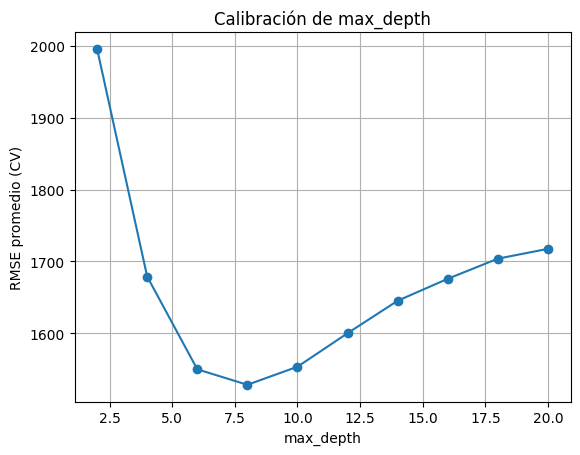

In [42]:
# Celda 5
# Primer hiperparámetro a estudiar: max_depth
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

depth_range = range(2, 21, 2) 
rmse_scores = []

# Evaluar cada valor usando validación cruzada (5-fold)
for depth in depth_range:
    rf = RandomForestRegressor(
        max_depth=depth,
    )
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    rmse_scores.append(-scores.mean())

min_max_depth = rmse_scores[0]
min_max_depth_index = 0

for d, s in zip(depth_range, rmse_scores):
    print(f"max_depth={d} -> RMSE promedio: {s}")
    if s < min_max_depth:
        min_max_depth = s
        min_max_depth_index = d
        
print(f"Mejor max_depth: {min_max_depth_index}")

# Gráfica para visualizar mejor
plt.plot(depth_range, rmse_scores, marker='o')
plt.title("Calibración de max_depth")
plt.xlabel("max_depth")
plt.ylabel("RMSE promedio (CV)")
plt.grid(True)
plt.show()


max_features=1 -> RMSE promedio: 1766.3460419935927
max_features=2 -> RMSE promedio: 1760.3443882989473
max_features=3 -> RMSE promedio: 1760.9490963531584
max_features=4 -> RMSE promedio: 1758.2743215105534
max_features=5 -> RMSE promedio: 1753.0149727914886
max_features=6 -> RMSE promedio: 1750.1797851159147
max_features=7 -> RMSE promedio: 1744.5974399046804
max_features=8 -> RMSE promedio: 1737.6720739758312
max_features=9 -> RMSE promedio: 1733.8431982820937
Mejor max_features: 9


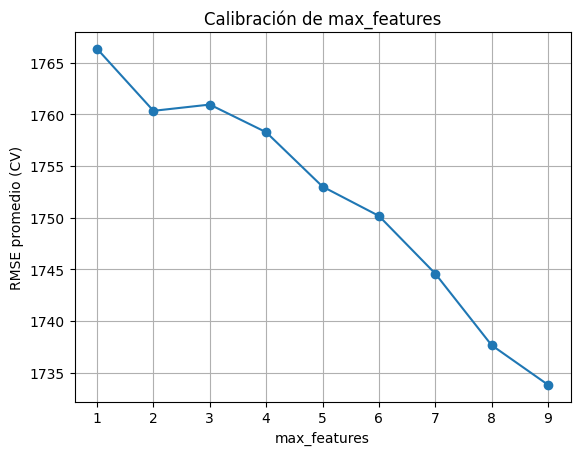

In [43]:
# Segundo hiperparámetro a estudiar: max_features

features_range = range(1, X_train.shape[1] + 1) 
rmse_scores = []

# Evaluar cada valor usando validación cruzada (5-fold)
for features in features_range:
    rf = RandomForestRegressor(
        max_features=features,
    )
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    rmse_scores.append(-scores.mean())

min_max_features = rmse_scores[0]
min_max_features_index = 0

for d, s in zip(features_range, rmse_scores):
    print(f"max_features={d} -> RMSE promedio: {s}")
    if s < min_max_features:
        min_max_features = s
        min_max_features_index = d
        
print(f"Mejor max_features: {min_max_features_index}")

# Gráfica para visualizar mejor
plt.plot(features_range, rmse_scores, marker='o')
plt.title("Calibración de max_features")
plt.xlabel("max_features")
plt.ylabel("RMSE promedio (CV)")
plt.grid(True)
plt.show()


n_estimators=10 -> RMSE promedio: 1774.832416414444
n_estimators=20 -> RMSE promedio: 1755.7675997716265
n_estimators=30 -> RMSE promedio: 1747.6491342415197
n_estimators=40 -> RMSE promedio: 1742.1344461076849
n_estimators=50 -> RMSE promedio: 1740.1530403188742
n_estimators=60 -> RMSE promedio: 1739.0028943706966
n_estimators=70 -> RMSE promedio: 1738.78085063053
n_estimators=80 -> RMSE promedio: 1732.673400344298
n_estimators=90 -> RMSE promedio: 1738.4851862441806
n_estimators=100 -> RMSE promedio: 1734.6200296377779
Mejor n_estimators: 80


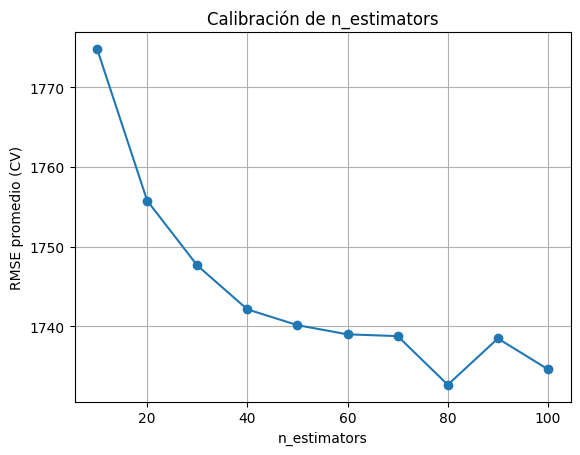

In [49]:
# Tercer hiperparámetro a estudiar: n_estimators

estimators_range = range(10, 110, 10) 
rmse_scores = []

# Evaluar cada valor usando validación cruzada (5-fold)
for estimators in estimators_range:
    rf = RandomForestRegressor(
        n_estimators=estimators,
    )
    scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    rmse_scores.append(-scores.mean())

min_n_estimators = rmse_scores[0]
min_n_estimators_index = 0

for d, s in zip(estimators_range, rmse_scores):
    print(f"n_estimators={d} -> RMSE promedio: {s}")
    if s < min_n_estimators:
        min_n_estimators = s
        min_n_estimators_index = d
        
print(f"Mejor n_estimators: {min_n_estimators_index}")

# Gráfica para visualizar mejor
plt.plot(estimators_range, rmse_scores, marker='o')
plt.title("Calibración de n_estimators")
plt.xlabel("n_estimators")
plt.ylabel("RMSE promedio (CV)")
plt.grid(True)
plt.show()


In [50]:
# Juntamos todos los hiperparámetros encontrados anteriormente en un único modelo

rf_model_opt = RandomForestRegressor(max_depth = min_max_depth_index, max_features = min_max_features_index, n_estimators = min_n_estimators_index)

rf_model_opt.fit(X_train, y_train)

y_pred_rf_opt = rf_model_opt.predict(X_test)

rmse_rf_opt = np.sqrt(mean_squared_error(y_test, y_pred_rf_opt))
mae_rf_opt = mean_absolute_error(y_test, y_pred_rf_opt)
r2_rf_opt = r2_score(y_test, y_pred_rf_opt)

print(f" RMSE random forest: {rmse_rf_opt}")
print(f" MAE random forest: {mae_rf_opt}")
print(f" R cuadrado random forest: {r2_rf_opt}")


 RMSE random forest: 1566.4681054876098
 MAE random forest: 1151.7177240737028
 R cuadrado random forest: 0.8395790443196463


###  Random Forest calibrado sklearn

Entrenamos un modelo de regresión utilizando `RandomForestRegressor` de la librería `sklearn`.

### Procedimiento

1. Creamos y calibramos un Randome Forest de regresión con el hiperparámetro `max_depth`, dejando los demás como vienen por defecto. Utilizamos cross validation con un k-fold de 5 para evaluar el modelo. Seleccionamos el mejor valor de `max_depth` basándonos en RMSE.
2. Creamos y calibramos un Randome Forest de regresión con el hiperparámetro `max_features`, dejando los demás como vienen por defecto. Utilizamos cross validation con un k-fold de 5 para evaluar el modelo. Seleccionamos el mejor valor de `max_features` basándonos en RMSE.
3. Creamos y calibramos un Randome Forest de regresión con el hiperparámetro `n_estimators`, dejando los demás como vienen por defecto. Utilizamos cross validation con un k-fold de 5 para evaluar el modelo. Seleccionamos el mejor valor de `n_estimators` basándonos en RMSE.
4. Creamos y calibramos un Randome Forest de regresión con todos los hiperparámetros encontrados anteriormente para finalmente hacer las predicciones en test y evaluar el modelo final.

### Parámetros calibrados

Los parámetros ajustados fueron:

- **`n_estimators`**: número de árboles en el modelo. Se evaluaron valores entre 10 y 100.
- **`max_features`**: cantidad de variables consideradas en cada división. Se evaluaron valores entre 1 y X_train.shape[1] (total de variables).
- **`max_depth`**: profundidad máxima de los árboles. Se evaluaron valores entre 2 y 20.

Finalmente los resultados obtenidos para cada hiperparámetro fueron:
- **`n_estimators`:** 80
- **`max_features`:** 9
- **`max_depth`**: 8

####  Resultados obtenidos en el conjunto de prueba:

- **RMSE (Root Mean Squared Error):** 1568.99
- **MAE (Mean Absolute Error):** 1153.65
- **R cuadrado (Mean Absolute Error):** 0.84

####  Comentario:
La calibración de hiperparámtros ha demostrado ser bastante efectiva, pues conseguimos el mejor modelo hasta el momento. Cada uno de los hiperparámetros evaluados tiene una función y aporta algo en particular al modelo:

- `n_estimators`: aumentarlo redujo la varianza del modelo, pero con un mayor costo computacional. A partir de un valor en concreto vimos que se que el RMSE se mantenía estable en niveles entre 1736 y 1731, por lo que en lugar de seleccionar el mejor, seleccionamos uno que permitiera un equilibrio entre la reducción de varianza y el costo computacional.
- `max_features`: permitir que los árboles usen todas las variables mejoró la precisión. En esta caso vimos que utilizar todas las variables resultó, con diferencia, ser la mejor de las opciones.
- `max_depth`: controlar la profundidad evitó el sobreajuste, logrando un buen equilibrio entre sesgo y varianza. Vimos que llegado a un punto el RMSE empieza a aumentar hasta estavilizarse, por lo que el criterio de elección fue el más bajo.

### Punto 6 - XGBoost con librería

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

In [ ]:
# Celda 6
from xgboost.sklearn import XGBRegressor
xgb = XGBRegressor()

xgb.fit(X_train, y_train)

y_pred_xgb= xgb.predict(X_test)

rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f" RMSE xgboost: {rmse_xgb}")
print(f" MAE xgboost: {mae_xgb}")
print(f" R cuadrado xgboost: {r2_xgb}")

 RMSE xgboost: 1621.4197004256812
 MAE xgboost: 1186.634392366123
 R cuadrado xgboost: 0.8281265175296673


###  XGBoost sklearn

Implementamos el modelo XGBoost utilizando la librería de `sklearn`. Este modelo se destaca por ser un método de **boosting** que construye árboles de manera secuencial, corrigiendo los errores del modelo anterior en cada iteración.

El procedimiento consistió en:

1. Generar un modelo XGBoost de regresión con sus valores por defecto.
2. Entrenar el modelo.
3. Predecir sobre el conjunto de prueba.
4. Calcular las métricas del modelo.

#### Configuración:

- La configuración por defecto de `sklearn`.

#### Resultados en el conjunto de prueba (`X_test`, `y_test`):
- RMSE (Root Mean Squared Error): 1621.42 
- MAE (Mean Absolute Error): 1186.63
- R cuadrado: 0.83

#### Comentario:
El modelo XGBoost ha resultado ser uno de los mejores modelos en cuanto a desempeño. Aunque en este caso no es mejor que el Random Forest calibrado es importante destacar que las métricas evaluadas para ambos modelos son muy cercanas pese a no haber hecho ningún proceso de calibración para este nuevo modelo. Esto lo que nos permite comprobar es que la forma en la que XGBoost corrige errores de manera secuencial durante el proceso de boosting muestra una clara mejora frente a otro modelos como Random Forest o un árbol de decisión tradicional.

### Punto 7 - Calibración de parámetros XGBoost

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

Learning_rate=0.001 -> RMSE promedio: 13622.899499162711
Learning_rate=0.01 -> RMSE promedio: 5722.259945765598
Learning_rate=0.1 -> RMSE promedio: 1519.5362432739007
Learning_rate=0.2 -> RMSE promedio: 1555.5668525902108
Learning_rate=0.3 -> RMSE promedio: 1580.1708797376523
Learning_rate=0.5 -> RMSE promedio: 1642.4354119496118
Learning_rate=0.7 -> RMSE promedio: 1706.944457744624
Learning_rate=0.9 -> RMSE promedio: 1768.5587526457489
Mejor learning_rate: 0.1


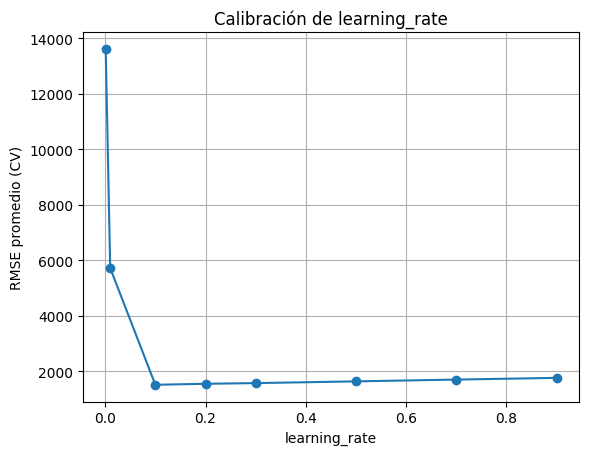

In [20]:
# Celda 7
# Primer hiperparámetro a estudiar: learning rate
learning_range = [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]
rmse_scores = []

# Evaluar cada valor usando validación cruzada (5-fold)
for rate in learning_range:
    xgb = XGBRegressor(
        learning_rate = rate
    )
    scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    rmse_scores.append(-scores.mean())

min_learning_rate = rmse_scores[0]
min_learning_rate_index = 0

for d, s in zip(learning_range, rmse_scores):
    print(f"Learning_rate={d} -> RMSE promedio: {s}")
    if s < min_learning_rate:
        min_learning_rate = s
        min_learning_rate_index = d
        
print(f"Mejor learning_rate: {min_learning_rate_index}")

# Gráfica para visualizar mejor
plt.plot(learning_range, rmse_scores, marker='o')
plt.title("Calibración de learning_rate")
plt.xlabel("learning_rate")
plt.ylabel("RMSE promedio (CV)")
plt.grid(True)
plt.show()


gamma=0 -> RMSE promedio: 1580.1708797376523
gamma=0.1 -> RMSE promedio: 1580.1708797376523
gamma=0.3 -> RMSE promedio: 1580.1708797376523
gamma=0.5 -> RMSE promedio: 1580.1708797376523
gamma=1 -> RMSE promedio: 1580.1708797376523
gamma=3 -> RMSE promedio: 1580.1708797376523
gamma=5 -> RMSE promedio: 1580.1708797376523
gamma=7 -> RMSE promedio: 1580.1708797376523
gamma=10 -> RMSE promedio: 1580.1708797376523
Mejor gamma: 0


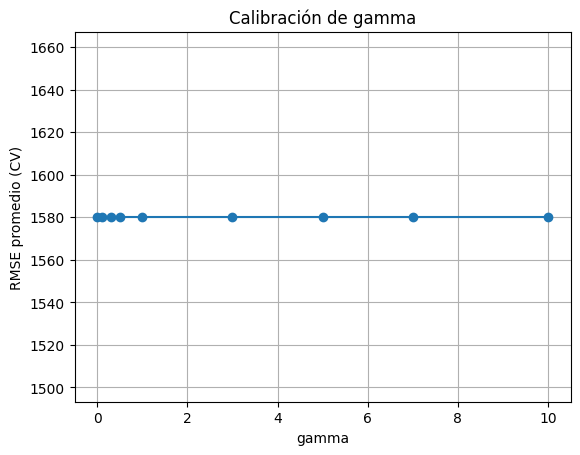

In [37]:
# Segundo hiperparámetro a estudiar: gamma
gamma_range = [0, 0.1, 0.3, 0.5, 1, 3, 5, 7, 10]
rmse_scores = []

# Evaluar cada valor usando validación cruzada (5-fold)
for gamma_ in gamma_range:
    xgb = XGBRegressor(
        gamma = gamma_
    )
    scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    rmse_scores.append(-scores.mean())

min_gamma = rmse_scores[0]
min_gamma_index = 0

for d, s in zip(gamma_range, rmse_scores):
    print(f"gamma={d} -> RMSE promedio: {s}")
    if s < min_gamma:
        min_gamma = s
        min_gamma_index = d
        
print(f"Mejor gamma: {min_gamma_index}")

# Gráfica para visualizar mejor
plt.plot(gamma_range, rmse_scores, marker='o')
plt.title("Calibración de gamma")
plt.xlabel("gamma")
plt.ylabel("RMSE promedio (CV)")
plt.grid(True)
plt.show()


colsample_bytree=0.1 -> RMSE promedio: 1604.9514163559538
colsample_bytree=0.2 -> RMSE promedio: 1604.9514163559538
colsample_bytree=0.3 -> RMSE promedio: 1528.6445059851553
colsample_bytree=0.4 -> RMSE promedio: 1531.1214816961744
colsample_bytree=0.5 -> RMSE promedio: 1546.0630136369043
colsample_bytree=0.6 -> RMSE promedio: 1548.2803505998047
colsample_bytree=0.7 -> RMSE promedio: 1554.3568938639594
colsample_bytree=0.8 -> RMSE promedio: 1558.8762178536858
colsample_bytree=0.9 -> RMSE promedio: 1567.1752384959855
colsample_bytree=1.0 -> RMSE promedio: 1580.1708797376523
Mejor colsample_bytree_range: 0.3


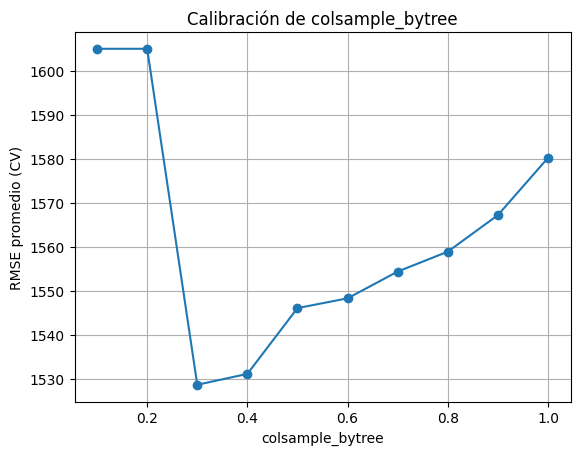

In [36]:
# Tercer hiperparámetro a estudiar: colsample_bytree
colsample_bytree_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
rmse_scores = []

# Evaluar cada valor usando validación cruzada (5-fold)
for colsample_bytree_ in colsample_bytree_range:
    xgb = XGBRegressor(
        colsample_bytree = colsample_bytree_
    )
    scores = cross_val_score(xgb, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
    rmse_scores.append(-scores.mean())

min_colsample_bytree = rmse_scores[0]
min_colsample_bytree_index = 0

for d, s in zip(colsample_bytree_range, rmse_scores):
    print(f"colsample_bytree={d} -> RMSE promedio: {s}")
    if s < min_colsample_bytree:
        min_colsample_bytree = s
        min_colsample_bytree_index = d
        
print(f"Mejor colsample_bytree_range: {min_colsample_bytree_index}")

# Gráfica para visualizar mejor
plt.plot(colsample_bytree_range, rmse_scores, marker='o')
plt.title("Calibración de colsample_bytree")
plt.xlabel("colsample_bytree")
plt.ylabel("RMSE promedio (CV)")
plt.grid(True)
plt.show()


In [ ]:
# Juntamos todos los hiperparámetros encontrados anteriormente en un único modelo

xgb_model_opt = XGBRegressor(learning_rate = min_learning_rate_index, gamma = min_gamma_index, colsample_bytree = min_colsample_bytree_index)

xgb_model_opt.fit(X_train, y_train)

y_pred_xgb_opt = xgb_model_opt.predict(X_test)

rmse_xgb_opt = np.sqrt(mean_squared_error(y_test, y_pred_xgb_opt))
mae_xgb_opt = mean_absolute_error(y_test, y_pred_xgb_opt)
r2_xgb_opt = r2_score(y_test, y_pred_xgb_opt)

print(f" RMSE XGBoost: {rmse_xgb_opt}")
print(f" MAE XGBoost: {mae_xgb_opt}")
print(f" R cuadrado XGBoost: {r2_xgb_opt}")


 RMSE XGBoost: 1592.9901499720816
 MAE XGBoost: 1177.1541927064538
 R cuadrado XGBoost: 0.8341008478144328


###  XGBoost calibrado sklearn

Entrenamos un modelo de regresión utilizando `XGBRegressor` de la librería `sklearn`.

### Procedimiento

1. Creamos y calibramos un XGBoost de regresión con el hiperparámetro `learning_rate`, dejando los demás como vienen por defecto. Utilizamos cross validation con un k-fold de 5 para evaluar el modelo. Seleccionamos el mejor valor de `learning_rate` basándonos en RMSE.
2. Creamos y calibramos un XGBoost de regresión con el hiperparámetro `gamma`, dejando los demás como vienen por defecto. Utilizamos cross validation con un k-fold de 5 para evaluar el modelo. Seleccionamos el mejor valor de `gamma` basándonos en RMSE.
3. Creamos y calibramos un XGBoost de regresión con el hiperparámetro `colsample_bytree`, dejando los demás como vienen por defecto. Utilizamos cross validation con un k-fold de 5 para evaluar el modelo. Seleccionamos el mejor valor de `colsample_bytree` basándonos en RMSE.
4. Creamos y calibramos un XGBoost de regresión con todos los hiperparámetros encontrados anteriormente para finalmente hacer las predicciones en test y evaluar el modelo final.

### Parámetros calibrados

Los parámetros ajustados fueron:

- **`gamma`**: número de árboles en el modelo. Se evaluaron valores entre 0 y 10.
- **`colsample_bytree`**: cantidad de variables consideradas en cada división. Se evaluaron valores entre 0.1 y 10.
- **`learning_rate`**: profundidad máxima de los árboles. Se evaluaron valores entre 0.001 y 0.9.

Finalmente los resultados obtenidos para cada hiperparámetro fueron:
- **`gamma`:** No afecto, se utilizó 0.1
- **`colsample_bytree`:** 0.3
- **`learning_rate`**: 0.1

####  Resultados obtenidos en el conjunto de prueba:

- **RMSE (Root Mean Squared Error):** 1592.99
- **MAE (Mean Absolute Error):** 1177.15
- **R cuadrado (Mean Absolute Error):** 0.83

####  Comentario:
La calibración de hiperparámtros ha demostrado ser bastante efectiva, pues conseguimos un modelo que resultó ser mejor que el XGBoost por defecto. Cada uno de los hiperparámetros evaluados tiene una función y aporta algo en particular al modelo:

- `learning_rate`: controla cuánto contribuye cada árbol al modelo final. Un valor de 0.1 nos permitió un aprendizaje progresivo sin convergencia prematura, mejorando la - generalización frente al valor por defecto que podría ser demasiado agresivo o conservador según los datos.
- `gamma`: determina la regularización mínima para crear una partición en un nodo. Aunque este parámetro no impactó significativamente en nuestro caso, probarlo fue necesario ya que en otros conjuntos de datos puede evitar divisiones demasiado específicas y reducir el sobreajuste.
- `colsample_bytree`: define qué fracción de columnas usar en cada árbol. El valor óptimo de 0.3 indica que usar solo el 30% de las variables en cada árbol redujo correlaciones y mejoró la robustez del modelo, algo que no se consigue con el valor por defecto (1.0) que usa todas las variables.

### Punto 8 - Comparación y análisis de resultados
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

In [54]:
# Celda 8
print(f"RMSE XGBoost: {rmse_xgb_opt}")
print(f"MAE XGBoost: {mae_xgb_opt}")
print(f"R cuadrado XGBoost: {r2_xgb_opt}")

print(f"\nRMSE random forest: {rmse_rf_opt}")
print(f"MAE random forest: {mae_rf_opt}")
print(f"R cuadrado random forest: {r2_rf_opt}")

RMSE XGBoost: 1592.9901499720816
MAE XGBoost: 1177.1541927064538
R cuadrado XGBoost: 0.8341008478144328

RMSE random forest: 1566.4681054876098
MAE random forest: 1151.7177240737028
R cuadrado random forest: 0.8395790443196463


El modelo de Random Forest obtuvo mejores resultados globales que XGBoost, mostrando menor error absoluto y cuadrático medio, y un mayor R², aunque esta diferencia es mínima. Esto sugiere que logró capturar mejor la estructura de los datos en este caso particular.

**Ventajas y desventajas de cada modelo:**

- **Random Forest** destaca por su robustez frente a sobreajuste, su simplicidad en la configuración de hiperparámetros y su capacidad para manejar relaciones no lineales y ruido en los datos. Sin embargo, al ser un método basado en bagging, puede ser menos eficiente computacionalmente y carece de algunos mecanismos avanzados de regularización.

- **XGBoost**, por otro lado, es un algoritmo más sofisticado que incorpora boosting secuencial, regularización y mayor eficiencia en grandes volúmenes de datos. En muchos contextos, suele superar a Random Forest en precisión. Sin embargo, es más sensible a la selección de hiperparámetros y requiere una calibración más cuidadosa para alcanzar su mejor rendimiento.

**Reflexión final:**

En este análisis, los hiperparámetros se estudiaron **de forma individual** y no en combinación, lo cual puede limitar la calidad de la optimización. Usar herramientas como `GridSearchCV` o `RandomizedSearchCV` permitiría explorar conjuntos de parámetros de forma conjunta, lo que podría mejorar el rendimiento del modelo XGBoost.

Aun así, es posible que, dada la naturaleza específica de los datos utilizados (como su tamaño, la relación entre variables o la presencia de ruido), el modelo de Random Forest sea más adecuado para este problema en particular.
